<a href="https://www.kaggle.com/code/mikedelong/eda-with-folium-map?scriptVersionId=138110308" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd 
import numpy as np
df = pd.read_csv('../input/list-of-airports-in-india/list-of-airports-in-india-hxl-tags-1.csv', parse_dates=['last_updated'],
                 infer_datetime_format=True,
                 skiprows=2, names=['id', 'ident', 'type', 'name', 'latitude_deg', 'longitude_deg', 'elevation_ft', 'continent',
                                    'iso_country', 'iso_region', 'municipality', 'scheduled_service', 'gps_code', 'iata_code',
                                    'local_code', 'home_link', 'wikipedia_link', 'keywords', 'score', 'last_updated'],
                dtype={'score': np.int32, 'latitude_deg': np.float32, 'longitud_deg': np.float32,
                      'elevation_ft': np.float32, 'scheduled_service': np.int32, 'id': np.int32,}).drop(columns=['continent', 'iso_country'])
df['updated_year'] = df['last_updated'].dt.year
df.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated,updated_year
0,26555,VIDP,large_airport,Indira Gandhi International Airport,28.566500,77.103104,777.0,IN-DL,New Delhi,1,VIDP,DEL,NaN,http://www.newdelhiairport.in/,http://en.wikipedia.org/wiki/Indira_Gandhi_Int...,Palam Air Force Station,51475,2017-12-15 03:08:58+00:00,2017
1,26434,VABB,large_airport,Chhatrapati Shivaji International Airport,19.088699,72.867897,39.0,IN-MM,Mumbai,1,VABB,BOM,NaN,http://www.csia.in/,http://en.wikipedia.org/wiki/Chhatrapati_Shiva...,"Bombay, Sahar International Airport",1014475,2013-04-12 01:27:48+00:00,2013
2,35145,VOBL,large_airport,Kempegowda International Airport,13.197900,77.706299,3000.0,IN-KA,Bangalore,1,VOBL,BLR,NaN,http://www.bengaluruairport.com/home/home.jspx,https://en.wikipedia.org/wiki/Kempegowda_Inter...,NaN,51200,2016-02-01 17:54:36+00:00,2016
3,26618,VOMM,large_airport,Chennai International Airport,12.990005,80.169296,52.0,IN-TN,Chennai,1,VOMM,MAA,NaN,NaN,http://en.wikipedia.org/wiki/Chennai_Internati...,NaN,51150,2008-12-07 02:26:07+00:00,2008
4,26444,VAGO,large_airport,Dabolim Airport,15.380800,73.831398,150.0,IN-GA,Vasco da Gama,1,VOGO,GOI,NaN,NaN,http://en.wikipedia.org/wiki/Dabolim_Airport,"Goa Airport, Dabolim Navy Airbase, दाबोळी विमानतळ",875,2013-04-27 02:00:28+00:00,2013


In [2]:
df.nunique()

id                   344
ident                344
type                   5
name                 341
latitude_deg         339
longitude_deg        338
elevation_ft         229
iso_region            35
municipality         164
scheduled_service      2
gps_code             234
iata_code            136
local_code            57
home_link             45
wikipedia_link       149
keywords              96
score                 23
last_updated         226
updated_year          12
dtype: int64

In [3]:
df.dtypes

id                                 int32
ident                             object
type                              object
name                              object
latitude_deg                     float32
longitude_deg                    float64
elevation_ft                     float32
iso_region                        object
municipality                      object
scheduled_service                  int32
gps_code                          object
iata_code                         object
local_code                        object
home_link                         object
wikipedia_link                    object
keywords                          object
score                              int32
last_updated         datetime64[ns, UTC]
updated_year                       int64
dtype: object

In [4]:
df.isna().sum()

id                     0
ident                  0
type                   0
name                   0
latitude_deg           0
longitude_deg          0
elevation_ft          79
iso_region             0
municipality         160
scheduled_service      0
gps_code             109
iata_code            207
local_code           287
home_link            299
wikipedia_link       193
keywords             247
score                  0
last_updated           0
updated_year           0
dtype: int64

<Axes: ylabel='Frequency'>

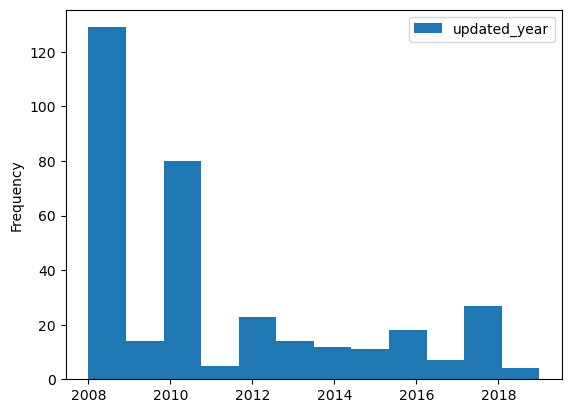

In [5]:
df['updated_year'].plot.hist(bins=1 + df['updated_year'].max() - df['updated_year'].min(), legend=True)

<Axes: >

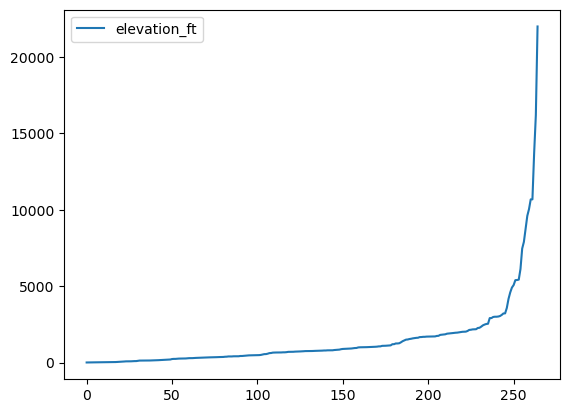

In [6]:
df[['elevation_ft']].sort_values(ascending=True, by='elevation_ft').reset_index().plot(kind='line', y='elevation_ft')

<Axes: >

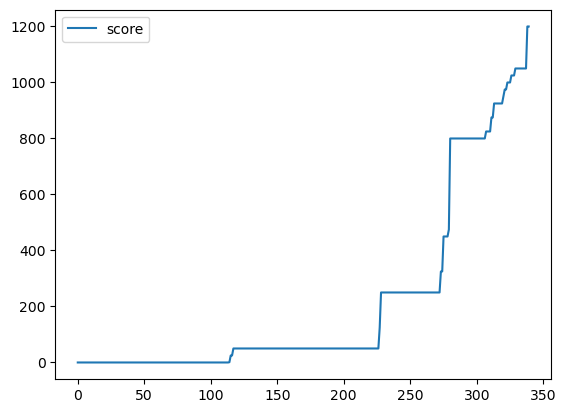

In [7]:
# we don't see the shape of the curve if we include the outliers so let's drop them
df[['score']][df['score'] < 10000].sort_values(ascending=True, by='score').reset_index().plot(kind='line', y='score')

<Axes: ylabel='score'>

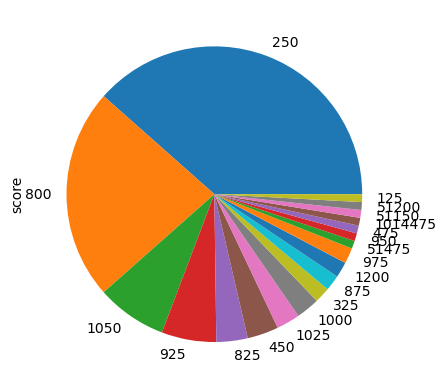

In [8]:
# let's make a pie chart for scores where the score is more than 50
df[df['score'] > 50]['score'].value_counts().plot(kind='pie')

<Axes: ylabel='scheduled_service'>

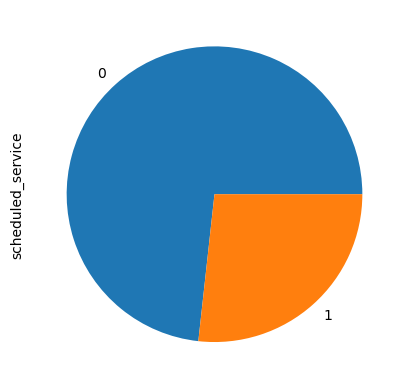

In [9]:
df['scheduled_service'].value_counts().plot(kind='pie')

<Axes: ylabel='type'>

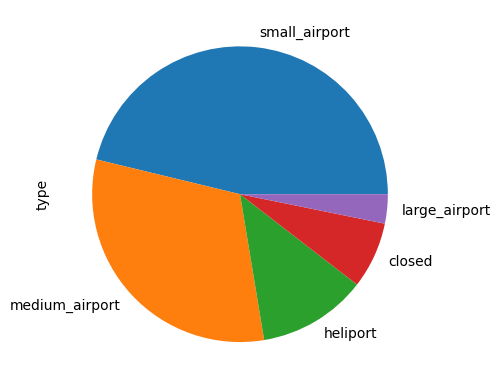

In [10]:
df['type'].value_counts().plot(kind='pie')

In [11]:
from folium import Icon
from folium import Map
from folium import Marker

# combine identifiers and remove nans to make clean identifiers
def make_popup(arg_row) ->str:
    if arg_row['gps_code'] == arg_row['ident']: 
        raw = [arg_row['gps_code'], arg_row['iata_code']]
    else:
        raw = [arg_row['gps_code'], arg_row['ident'], arg_row['iata_code']]
    return '/'.join([item for item in raw if isinstance(item, str)])
        
# let's ignore the closed airports and map the others with colors that match the pie chart above
color = {'small_airport': 'blue', 'medium_airport': 'orange', 'large_airport': 'purple', 'heliport': 'green'}
# for some reason we have to fudge the center a little
lon_fudge = 0
location_map = Map(location=[df['latitude_deg'].mean(), df['longitude_deg'].mean() + lon_fudge], zoom_start=5)
for index, row in df[df['type'] != 'closed'].iterrows():
    popup = make_popup(arg_row=row)
    Marker([row['latitude_deg'], row['longitude_deg']], popup=popup,
           icon=Icon(color=color[row['type']])
          ).add_to(parent=location_map)

location_map